# K-means кластеризація для сегментації користувачів, заснованої на RFM змінних

Вирішуватимемо задачу сегментації користувачів, виходячи з їх нещодавності та частоти покупок, а також сум витрат на них.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install missingno
import missingno as msno
import datetime as dt
import seaborn as sns
import numpy as np
!pip install -U feature-engine
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

Будемо використовувати набір даних із наступного джерела: https://archive.ics.uci.edu/ml/datasets/online+retail 

1.Завантажуємо набір даних із файлу. Виведимо перші 5 записів та розмір набору даних.

In [2]:
df = pd.read_excel(r"C:\Data\Online Retail.xlsx")
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Підготовка даних

2.Проведемо невеликий аналіз даних.
2.1.Виведемо результат методу describe() для числових колонок та кількість унікальних значень у кожній категоріальній колонці.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
df.select_dtypes(exclude='number').nunique().reindex(df.columns)

InvoiceNo      25900.0
StockCode       4070.0
Description     4223.0
Quantity           NaN
InvoiceDate    23260.0
UnitPrice          NaN
CustomerID         NaN
Country           38.0
dtype: float64

2.1.1.Як можна пояснити те, що у змінних Quantity і UnitPrice мінімальне значення негативне?

In [8]:
df[df["Quantity"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [9]:
df[df["Quantity"]==-80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


Негативне значення у змінної Quantity означає відміну. Про це також свідчить "c" на початку InvoiceNo.

In [10]:
df[df["UnitPrice"]<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [11]:
df[df["UnitPrice"]==-11062.06]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Негативне значення у змінної UnitPrice означає коригування безнадійної заборгованості.

Негативні значення Quantity та UnitPrice можна видалити, оскільки для нашого аналізу цікаві лише покупки, які здійснив користувач сайту.

In [17]:
df1 = df[(df['Quantity']>0) & (df["UnitPrice"]>0)]
df1.shape

(530104, 8)

In [18]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


2.2.Виведемо відсоток відсутніх значень у кожній із колонок.

<AxesSubplot:>

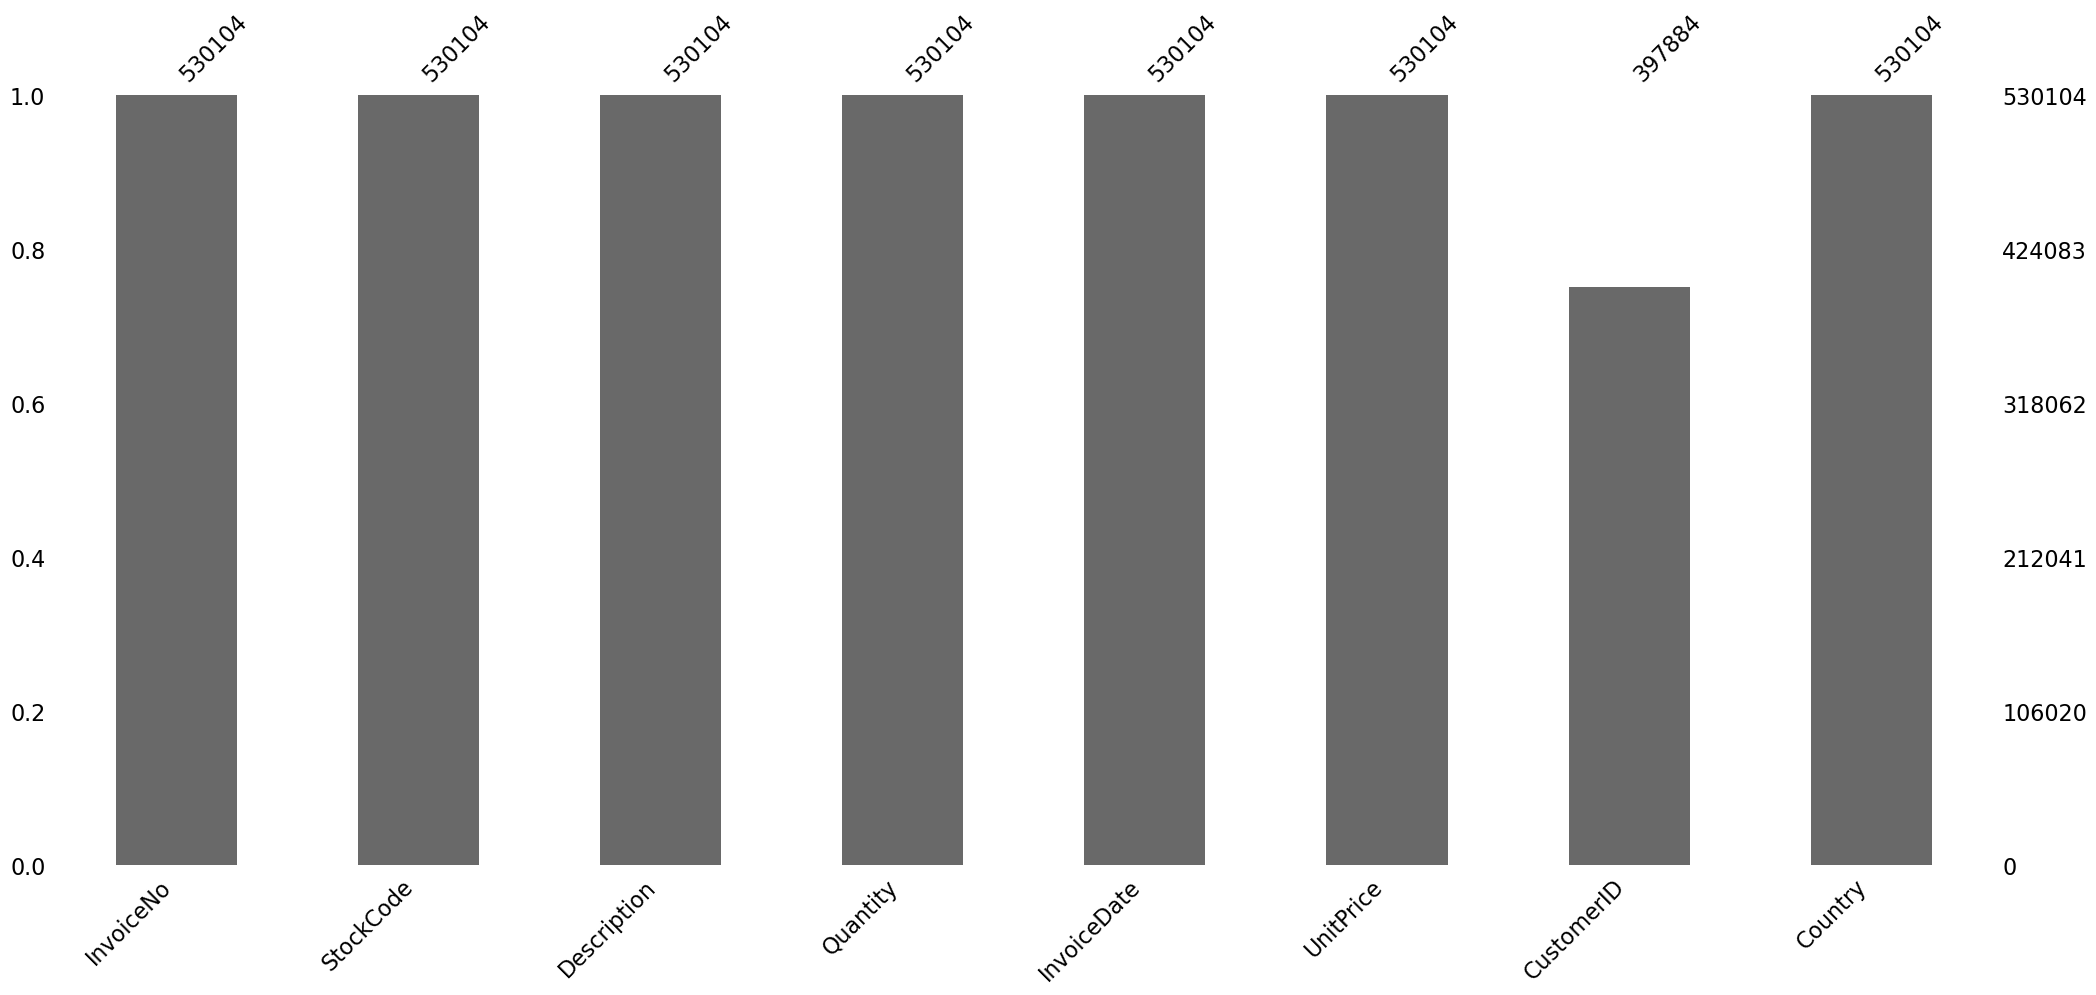

In [19]:
msno.bar(df1)

In [20]:
nan = (df1.isna().sum() / len(df1)) * 100
nan = nan.drop(nan[nan == 0].index).sort_values(ascending=False)
count_na = pd.DataFrame({'Missing %' :nan})
count_na

,Missing %
CustomerID,24.942275


In [21]:
df1.isnull().mean()*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.000000
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.942275
Country         0.000000
dtype: float64

In [22]:
df1.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

2.4. Видалити рядки з відсутніми значеннями (видаляємо відсутні значення CustomerID, так як аналіз оснований на клієнтах)

In [23]:
df2 = df1[pd.notnull(df1['CustomerID'])]

In [24]:
df2.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

2.5. Виведемо значення змінної Country, відсортувавши їх за відсотком присутності в даних.
Тобто вгорі має бути значення, яке найчастіше є у даних.

In [26]:
df2['Country'].value_counts(normalize=True)*100

United Kingdom          89.051332
Germany                  2.272019
France                   2.096340
EIRE                     1.818621
Spain                    0.624303
Netherlands              0.592886
Belgium                  0.510450
Switzerland              0.462698
Portugal                 0.367444
Australia                0.297072
Norway                   0.269174
Italy                    0.190508
Channel Islands          0.187994
Finland                  0.172161
Cyprus                   0.154316
Sweden                   0.113350
Austria                  0.100029
Denmark                  0.095505
Poland                   0.082939
Japan                    0.080677
Israel                   0.062330
Unspecified              0.061324
Singapore                0.055795
Iceland                  0.045742
USA                      0.044988
Canada                   0.037951
Greece                   0.036443
Malta                    0.028149
United Arab Emirates     0.017090
European Commu

2.6.У наборі даних є значення змінної Country, яке зустрічається найчастіше.
Відфільтруйємо дані лише до тих записів, які мають значення змінної Country. Це спростить нам задачу, до того ж для інших значень Country обмаль даних.

In [27]:
df3 = df2.loc[df2['Country'] == 'United Kingdom']

In [28]:
df3.Country.unique()

array(['United Kingdom'], dtype=object)

2.7. Створюємо стовпець Date із значень у стовпці InvoiceDate. Стовпець Date повинен містити дату у форматі рік-місяць-день, наприклад "2021-10-24".

In [29]:
df3['Date']=pd.to_datetime(df3['InvoiceDate'], format='%Y-%m-%d').dt.floor('D')
df3['Date']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541889   2011-12-09
541890   2011-12-09
541891   2011-12-09
541892   2011-12-09
541893   2011-12-09
Name: Date, Length: 354321, dtype: datetime64[ns]

Отже, на даний момент у нас є всі необхідні дані для вирішення задачі:

Customer ID
Unit Price
Quantity
Invoice Date

In [30]:
df3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [31]:
df3.shape

(354321, 9)

## RFM

Давність-частота-грошовий вираз (Recency-Frequency-Monetary)
    
    
RFM-аналіз дозволяє сегментувати клієнтів за частотою та вартістю покупок та визначати тих клієнтів, які витрачають найбільше грошей.

* Давність - скільки часу пройшло з того часу, як клієнт щось купив у нас.
* Частота - як часто клієнт купує у нас.
* Грошовий вираз - загальна вартість покупок, здійснених покупцем.

Логічно припустити з опису вище, що **дані мають бути згруповані за клієнтами**. Інакше немає сенсу виводити Recency та Частоту.

3.1.Визначаємо останню дату транзакції у наборі даних. Ця дата нам необхідна, щоб визначати, як давно користувач робив покупку. Але дані історичні і якщо ми візьмемо для розрахунку recency фактичну сьогоднішню дату, розподіл recency буде зрушений у бік кількох сотень днів.
Щоб розподіл recency розпочинався з нуля, за дату "сьогодні" ми візьмемо дату останньої транзакції в наборі даних. Запишемо знайдену дату змінної NOW.

In [32]:
df3['Date'].min()

Timestamp('2010-12-01 00:00:00')

In [33]:
NOW1=df3['Date'].max()
NOW1

Timestamp('2011-12-09 00:00:00')

In [34]:
NOW = dt.date(2011,12,9)

### Recency

3.2.У змінну R_df запишемо recency dataframe, що складається з колонок CustomerID, Last_Purchase_Date та Recency,
де     
   - Last_Purchase_Date - це дата останньої покупки клієнта;
   - Recency - скільки днів минуло з дати останньої покупки клієнта до NOW.

In [35]:
R_df = df3.groupby(['CustomerID'],as_index=False)['Date'].max()
R_df.columns = ['CustomerID','Last_Purchase_Date']
R_df['Last_Purchase_Date'] = pd.DatetimeIndex(R_df.Last_Purchase_Date).date
R_df.head()

,CustomerID,Last_Purchase_Date
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [36]:
Recency = R_df.Last_Purchase_Date.apply(lambda x : (NOW - x).days)
R_df['Recency']=Recency
R_df.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


### Frequency - Monetary

3.3.Створимо Frequency - Monetary dataframe у змінній FM_df.  
Датафрейм повинен містити
- CustomerID - ідентифікатор клієнта
- Frequency - кількість покупок клієнта (кількість унікальних інвойсів)
- Monetary - скільки грошей у магазині витратив клієнт

In [37]:
frequency_df = df3.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,209
3,12749.0,5
4,12820.0,4


In [40]:
df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
df3

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,2011-12-09,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,2011-12-09,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,2011-12-09,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,2011-12-09,214.80


In [41]:
monetary_df=df3.groupby('CustomerID',as_index=False)['TotalPrice'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33719.73
3,12749.0,4090.88
4,12820.0,942.34


In [42]:
FM_df = frequency_df.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')
FM_df.head()

,CustomerID,Frequency,Monetary
0,12346.0,1,77183.60
1,12747.0,11,4196.01
2,12748.0,209,33719.73
3,12749.0,5,4090.88
4,12820.0,4,942.34


### RFM
3.4.Створимо RFM_df, який є об'єднанням R_df та FM_df за ідентифікатором клієнта.

In [43]:
RFM_df=R_df.merge(FM_df,left_on='CustomerID',right_on='CustomerID')
RFM_df.head()

,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,325,1,77183.60
1,12747.0,2011-12-07,2,11,4196.01
2,12748.0,2011-12-09,0,209,33719.73
3,12749.0,2011-12-06,3,5,4090.88
4,12820.0,2011-12-06,3,4,942.34


## K-means для RFM сегментації

K-means дає кращий результат за наступних умов:
- Розподіл даних не спотворений (тобто немає довгих хвостів)
- Дані стандартизовані (тобто середнє значення 0 та стандартне відхилення 1).

4.1.Побудуємо діаграми розподілу даних (наприклад, sns.distplot) для колонок Recency, Frequency і Monetary RFM_df.
Виведемо коефіцієнт асиметрії кожної з колонок.

Проаналізуємо отримані графіки. Визначимо при якій кількості кластерів на основі з візуалізацій найкраще поділяються дані на кластери.

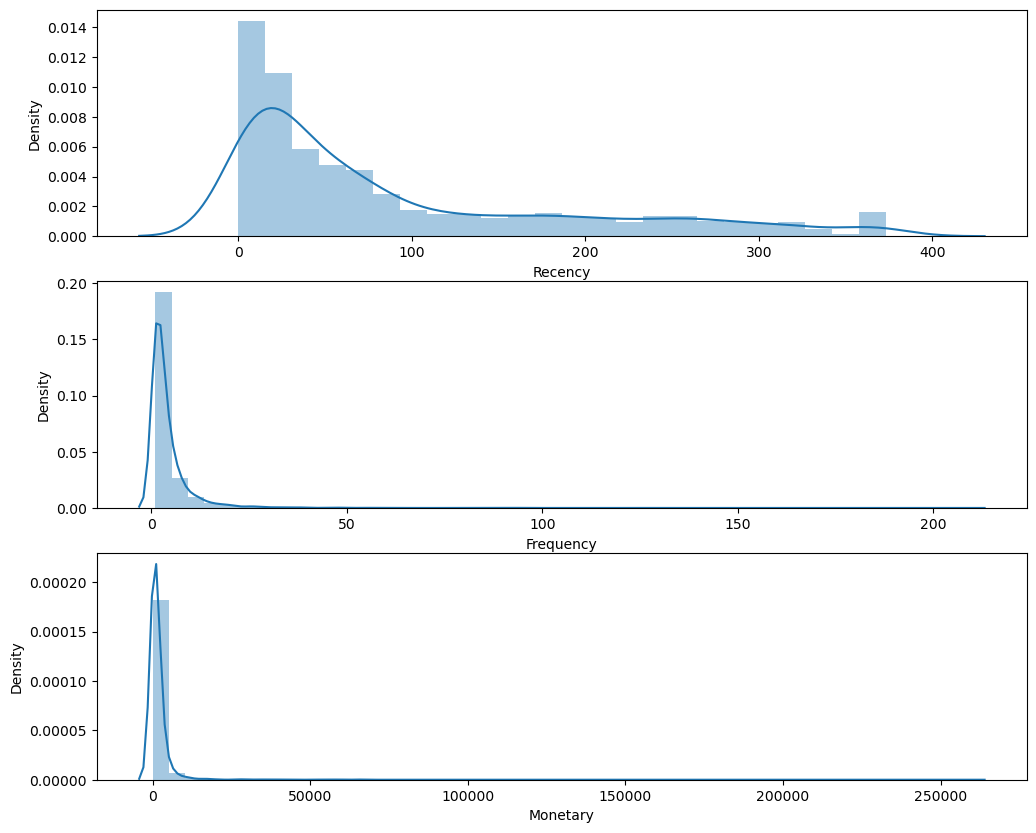

In [44]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df['Monetary'])
plt.show()

In [45]:
RFM_df.skew(axis = 0,skipna = True)

CustomerID    -0.011530
Recency        1.244993
Frequency     10.751932
Monetary      20.198459
dtype: float64

Дані сильно перекручені, тому ми виконаємо над ними log перетворення, щоб зменшити асиметрію кожної змінної.

4.2.Над кожною зі змінних 'Recency', 'Frequency', 'Monetary' виконуємо перетворення log(x+1).   
Додаємо константу, оскільки log перетворення вимагає, щоб усі значення були позитивними.
Відобразимо розподіл змінних після перетворення.

In [46]:
RFM_log = RFM_df.loc[:,"Recency":"Monetary"]
RFM_log['Recency']=np.log1p(RFM_log['Recency'])
RFM_log['Frequency']=np.log1p(RFM_log['Frequency'])
RFM_log['Monetary']=np.log1p(RFM_log['Monetary'])

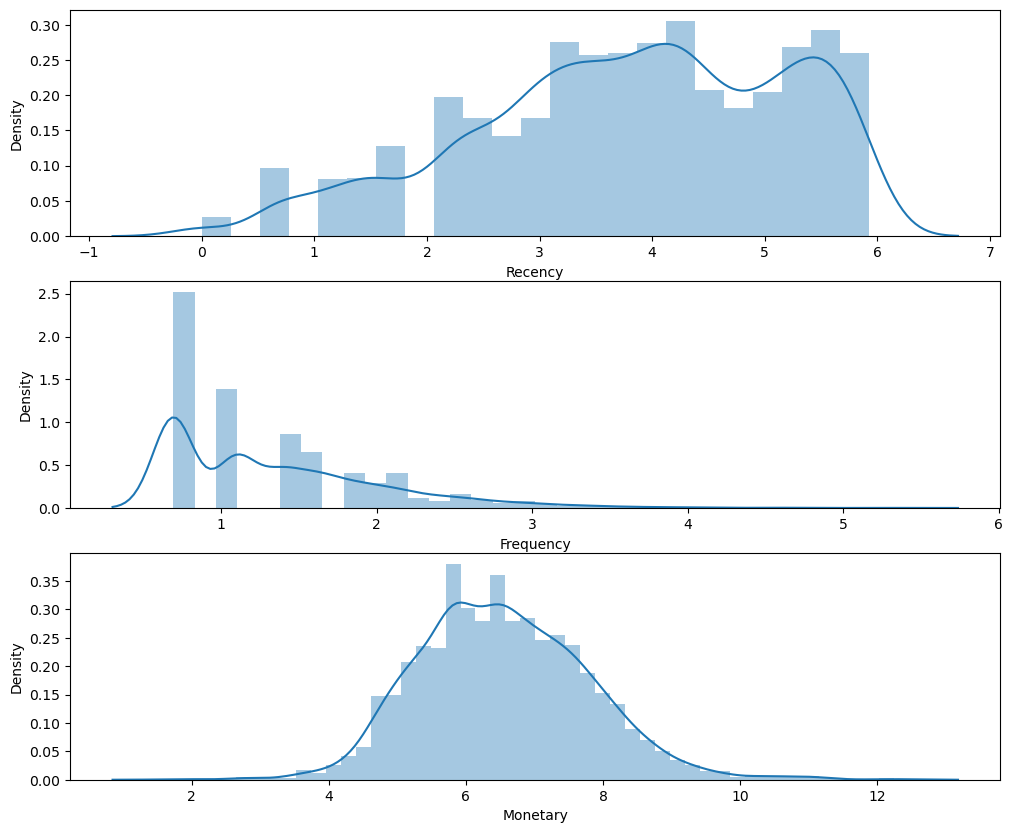

In [47]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(RFM_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_log['Monetary'])
plt.show()

4.3.Бачимо, що в нас все одно залишилися хвости. Приберемо їх з використанням техніки **Winsorizing**.    

Прочитати про неї тут: https://en.wikipedia.org/wiki/Winsorizing.    

Для використання техніки будемо використовувати бібліотеку [feature_engine](https://feature-engine.readthedocs.io/en/1.1.x/).   


Нам потрібний об'єкт Winsorizer. Імпортуємо його за допомогою
`from feature_engine.outliers import Winsorizer`.

У змінній windsoriser створимо екземпляр класу Winsorizer зі значеннями змінних 'tail='both'', 'fold=2', а в 'variables' передаємо назви змінних, які ми хочемо перетворити.
Викликаємо метод fit().

In [48]:
windsoriser = Winsorizer(capping_method='gaussian',tail='both', fold=2, variables=['Recency', 'Frequency', 'Monetary'])

In [49]:
windsoriser.fit(RFM_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

Викликаємо трансформацію:

In [50]:
RFM_log_t = windsoriser.transform(RFM_log)

4.4. Стандартизуємо наші RFM змінні так, щоб середнє було 0, а стандартне відхилення дорівнювало 1. Тут не треба ділити на трейн і тест, можемо працювати разом з повним набором даних.

In [51]:
scaler = StandardScaler()
scaler.fit(RFM_log_t)
RFM_Table_scaled = scaler.transform(RFM_log_t)

In [52]:
RFM_Table_scaled=pd.DataFrame(RFM_Table_scaled, columns=RFM_log_t.columns)
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,1.465314,-1.016749,2.144184
1,-2.017962,1.868889,1.551863
2,-2.065658,2.232598,2.144184
3,-1.804222,0.752572,1.530119
4,-1.804222,0.458942,0.272403


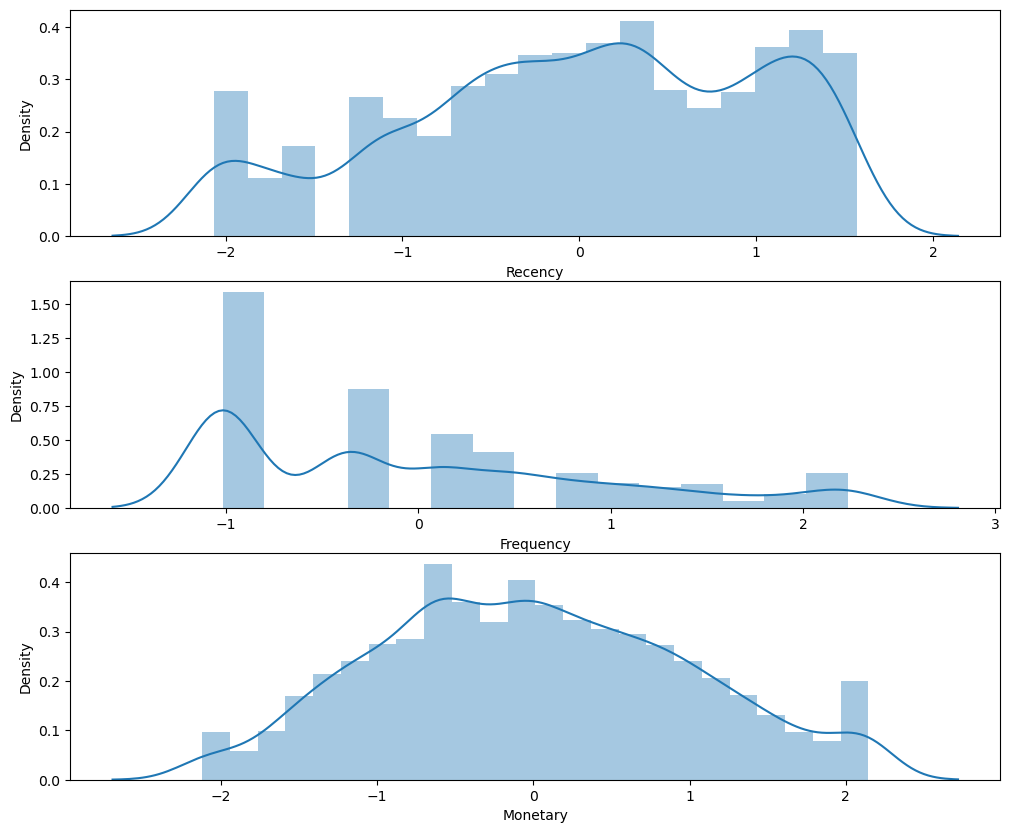

In [53]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(RFM_Table_scaled['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_Table_scaled['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_Table_scaled['Monetary'])
plt.show()

4.5. Знайдемо оптимальну кількість кластерів за допомогою Elbow Method.
Запустимо KMeans кластеризацію підготовлених стандартизованих RFM даних з параметром K від 1 до 10 включно.
Виконати це можна у циклі.
Відобразимо графічно отримані результати про значення сум внутрішньокластерних відстаней (у sklearn його називають inertia) для різних значень K.

In [54]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

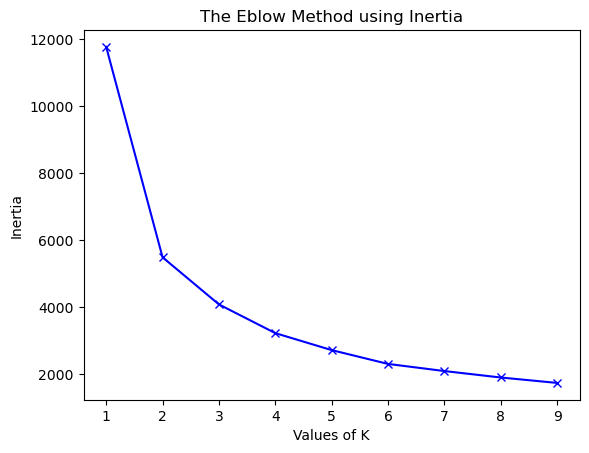

In [55]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Eblow Method using Inertia')
plt.show()

Значення кластера, при якому зменшення значення inertia стає постійним, можна вибрати як правильне значення кластера для наших даних.
Спробуємо використовувати значення К від 3 до 5.

4.6.Створимо функцію, яка прийматиме набір даних для навчання (стандартизовані дані), значення К та набір даних з оригінальними (до стандартизації) значеннями (назвем його original_df_rfm).

Усередині функції необхідно
1. Навчити на стандартизованих даних Kmeans з кількістю кластерів К, що є аргументом функції.
2. Отримати ідентифікатори кластерів (лейбли).
3. Створити новий датафрейм як копію original_df_rfm.
4. До набору даних, отриманого в п.3, додати колонку зі значенням кластера для даного рядка.
5. Виконати зменшення розмірності за допомогою TSNE (можна спробувати замість TSNE використовувати PCA, і візуально порівняти результати).
6. Відобразити результати кластеризації.

Запустимо функцію для значень K = {3,4,5}.
**Наша мета** - за допомогою візуалізацій зрозуміти, яка кількість кластерів оптимальна.

In [56]:
from sklearn.manifold import TSNE

def fit_visualize_kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    
    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Копия original_df_rfm с доп колонкой, содержащей лейблы кластеров
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Инициируем TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Визуализируем результаты TSNE трансформации
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    params = dict(
        x=transformed[:,0], 
        y=transformed[:,1],
        hue=cluster_labels, 
        style=cluster_labels, 
        palette="Set1"
    )
    sns.scatterplot(**params)
    return df_new

In [57]:
RFM_df.head()

,CustomerID,Last_Purchase_Date,Recency,Frequency,Monetary
0,12346.0,2011-01-18,325,1,77183.60
1,12747.0,2011-12-07,2,11,4196.01
2,12748.0,2011-12-09,0,209,33719.73
3,12749.0,2011-12-06,3,5,4090.88
4,12820.0,2011-12-06,3,4,942.34


In [58]:
RFM_df1=RFM_df.drop('Last_Purchase_Date', axis=1)
RFM_df1.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,11,4196.01
2,12748.0,0,209,33719.73
3,12749.0,3,5,4090.88
4,12820.0,3,4,942.34


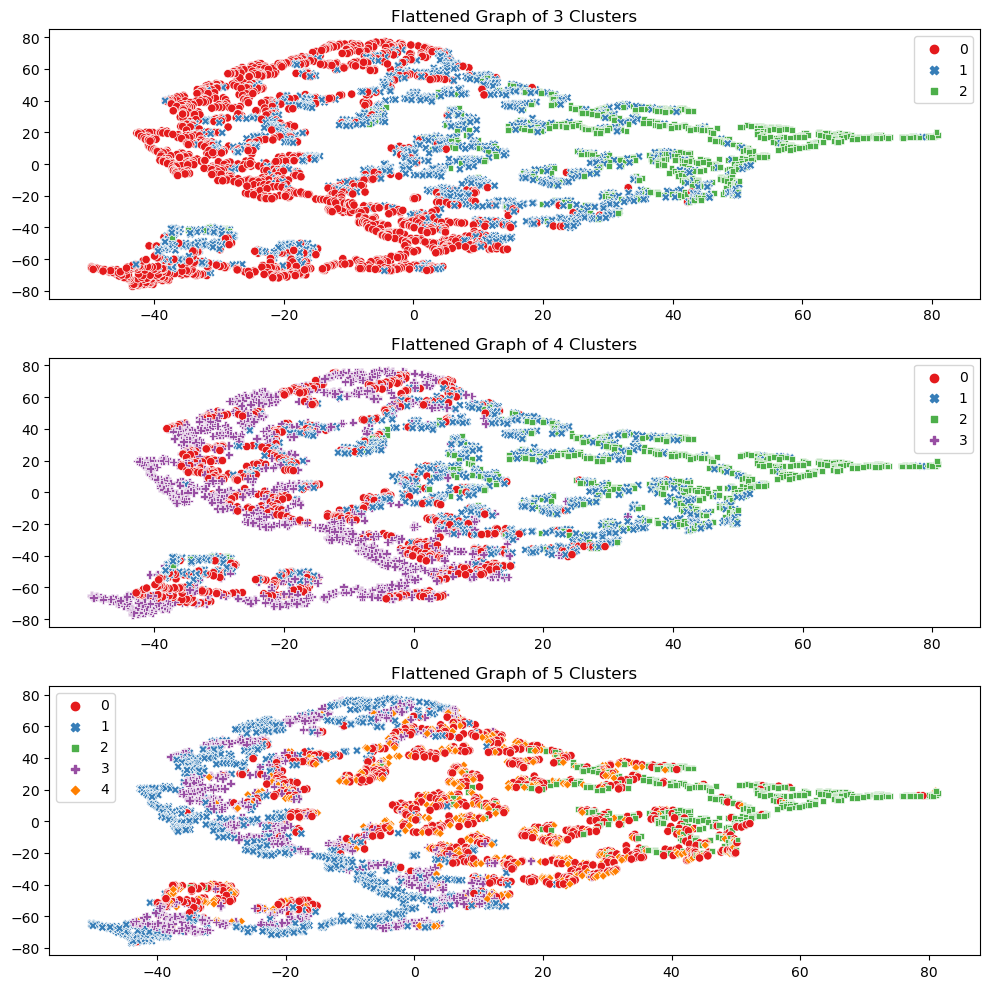

In [59]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = fit_visualize_kmeans(RFM_Table_scaled, 3, RFM_df1)

plt.subplot(3, 1, 2)
df_rfm_k4 = fit_visualize_kmeans(RFM_Table_scaled, 4, RFM_df1)

plt.subplot(3, 1, 3)
df_rfm_k5 = fit_visualize_kmeans(RFM_Table_scaled, 5, RFM_df1)

plt.tight_layout()

Проаналізувавши графіки бачимо, що при 4 кластерах дані найкраще поділяються.

4.7.Збудуємо додатково [Snake plots](https://www.marketingprofs.com/tutorials/snakeplot.asp), які часто використовують у маркетингових аналізах. 

Напишемо функцію для її реалізації.
У функції має відбуватися таке:
1. Створюємо датафрейм normalised_df_rfm, який містить оригінальні CustomerID, стандартизовані значення Recency, Frequency, Monetary та номер кластера.
2. Візуалізуємо датафрейм. 

Визначаємо відповідні аргументи функції. Вона має запускатися для різних результатів кластеризації.
Функція snake_plot може приймати декілька параметрів.

In [60]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_df1.index, 
                                       columns=RFM_df1.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']
    # "Розправляємо " дані в довгий формат
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    return

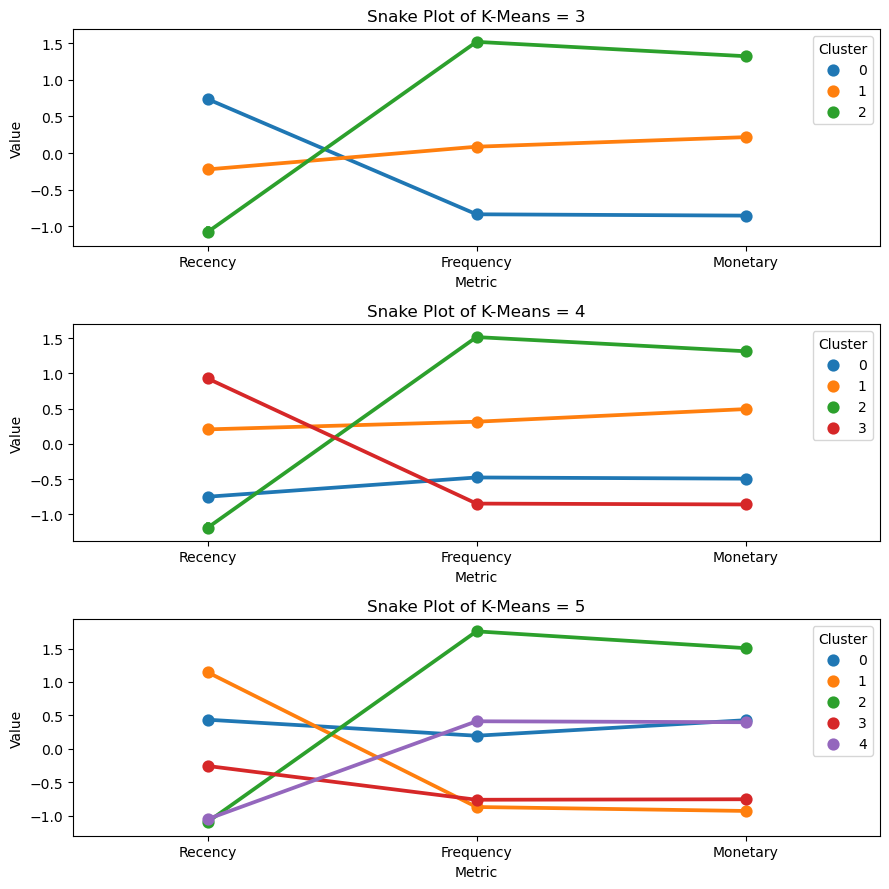

In [61]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_df1)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_df1)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_df1)

plt.tight_layout()

Зі згладжених графіків і графіків-змій видно, що значення кластера, що дорівнює 4, добре сегментує наших клієнтів.
Ми також могли б піти на більшу кількість кластерів, що повністю залежить від того, як компанія хоче сегментувати своїх клієнтів. Але зазвичай 4 кластери – це зручно.

4.8.Інтерпретуємо результати кластеризації.
З результатів кластеризації з кількістю кластерів 4 (і оригінальними значеннями RFM змінних) сформуємо агрегат , який містить середнє значення по кожній із трьох колонок та кількість клієнтів у кластері.
Виведемо цей агрегат.

In [62]:
def RFM_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new


RFM_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          20.0       2.0    471.0   745
1          77.0       4.0   1572.0  1038
2          13.0      12.0   6319.0   776
3         187.0       1.0    311.0  1361

Висновки про отримані результати:

    1 кластер - клієнти, які можуть бути потенційно постійними користувачами, адже вони не так давно здійснювали останню покупку та вже поверталися на сайт. Продавцеві необхідно звернути увагу на цих клієнтів, продовжувати заохочувати та втримувати їх.
    2 кластер - клієнти, які вже давно нічого не купували, але раніше приносили хороший дохід.
    3 кластер - "золоті" клієнти, які є сновними користувачами, що приносять дохід. Так як здійснювали останню покупку нещодавно, мають найбільшу кількість здійснених замовлень на достатньо велику суму.
    4 кластер - "випадкові" клієнти, які потрапили на сайт, зробили по одному невеликому замовленню і більше його послугами давно не користувалися. Продавецеві потрібно розробити стратегію(маркетингову і тд), яка б змусила клієнта, ще повертатися на сайт.